# Project Telco

* Learn to discern what turns customers to churn

## Goal

* Discover drivers of churn of Telco customers
* Use drivers to develop a machine learning model to classify churn as a customer ending their contract or not ending (renewing) their contract with Telco

## Imports

In [1]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import wrangle as w
import explore as e
# import modeling as m

## Acquire

* Data acquired from Codeup MySQL DB
* Data initially acquired on 25 Apr 2023
* It contained 7,043 rows and 21 columns before cleaning
* Each row represents a unique customer of Telco
* Each column represents an element of the customer account

## Prepare

**Prepare Actions**:

* Removed columns that did not contain useful information
* Renamed columns to promote readability
* Checked for nulls in the data
    - total_charges nulls matched tenure of 0, therefore changed nulls to 0
* Checked that column data types were appropriate
* Added additional features to investigate:
    - has internet package
* Encoded categorical variables
    - turned 'Yes'/'No' to 1/0
* Split data into train, validate and test (approx. 60/20/20), stratifying on 'churn'
* Outliers have not been removed for this iteration of the project

In [2]:
# acquire, clean, and prepare the data
df = w.wrangle_telco_data()

# split into train, validate, and test datasets
train, validate, test = w.split_data(df, 'churn')

csv file found and loaded
data cleaned and prepped
data split
train -> (4225, 44); 59.99%
validate -> (1409, 44); 20.01%
test -> (1409, 44); 20.01%


#### A brief look at the data

In [3]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,phone_service,multiple_lines,internet_service_type,online_security,online_backup,...,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,has_int_pack
2332,3338-CVVEH,Male,0,0,0,1,Yes,Fiber optic,No,No,...,0,1,0,0,1,0,0,1,0,1
5275,7442-YGZFK,Male,0,0,0,1,Yes,DSL,No,No,...,0,0,0,0,0,0,1,0,0,0
6429,9102-OXKFY,Male,0,0,0,1,Yes,DSL,No,No,...,0,0,0,1,0,0,1,0,0,1
89,0141-YEAYS,Female,1,0,0,1,Yes,Fiber optic,No,Yes,...,0,0,0,0,1,0,0,0,0,1
6412,9079-YEXQJ,Female,0,0,0,1,Yes,Fiber optic,No,Yes,...,0,1,0,0,1,0,0,1,0,1


#### A summary of the data

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,4225.0,0.159053,0.365769,0.0,0.00,0.00,0.00,1.00
partner,4225.0,0.479527,0.499640,0.0,0.00,0.00,1.00,1.00
dependents,4225.0,0.305562,0.460700,0.0,0.00,0.00,1.00,1.00
phone_service,4225.0,0.907219,0.290160,0.0,1.00,1.00,1.00,1.00
paperless_billing,4225.0,0.604260,0.489067,0.0,0.00,1.00,1.00,1.00
monthly_charges,4225.0,65.273243,30.218179,18.4,36.45,70.75,90.35,118.75
total_charges,4225.0,2320.103183,2297.297588,0.0,392.65,1414.80,3902.45,8684.80
tenure,4225.0,32.562367,24.755164,0.0,9.00,29.00,56.00,72.00
churn,4225.0,0.265325,0.441559,0.0,0.00,0.00,1.00,1.00
female,4225.0,0.496095,0.500044,0.0,0.00,0.00,1.00,1.00


## Explore

* Is Churn independent from payment type?
* Is Churn independent from internet Service type?
* Is Churn independent from tech support?
* Is Churn independent from a customer having at least one internet package?

### 1) Is Churn independent from payment type?
* `Churn` is **NOT** independent from `payment type`
* Discrete (churn) vs Discrete (payment_type) = $Chi^2$
    - $Chi^2$ = 411.59356 
    - $p$ = 6.820556e-89
* $H_0$: Churn is independent from payment type
* $H_a$: Churn is **NOT** independent from payment type

Chi2: 411.5935596871652, p-value: 6.820556365758793e-89


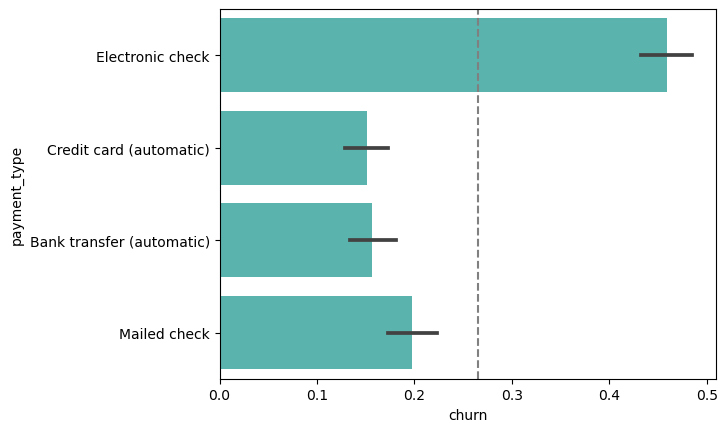

In [5]:
e.explore_cat(train,'churn','payment_type')

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that payment type and churn are not independent from each other. I believe that using `payment_type` in the modeling will have a positive impact on the accuracy.**

### 2) Is Churn independent from internet Service type?
* `Churn` is **NOT** independent from `internet service type`
* Discrete (churn) vs Discrete (internet_service_type) = $Chi^2$
    - $Chi^2$ = 402.162525
    - $p$ = 4.693721e-88
* $H_0$: Churn is independent from internet service type
* $H_a$: Churn is **NOT** independent from internet service type

Chi2: 402.162525170296, p-value: 4.693720719529299e-88


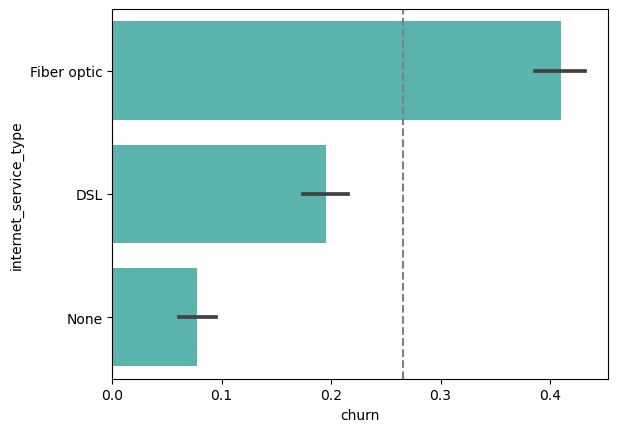

In [6]:
e.explore_cat(train,'churn','internet_service_type')

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that internet service type and churn are not independent from each other. I believe that using `internet_service_type` in the modeling will have a positive impact on the accuracy.**

### 3) Is Churn independent from tech support?
* `Churn` is **NOT** independent from `tech support`
* Discrete (churn) vs Discrete (tech_support) = $Chi^2$
    - $Chi^2$ = 510.699959
    - $p$ = 1.267398e-111
* $H_0$: Churn is independent from tech support
* $H_a$: Churn is **NOT** independent from tech support

Chi2: 510.6999585704251, p-value: 1.2673980725639105e-111


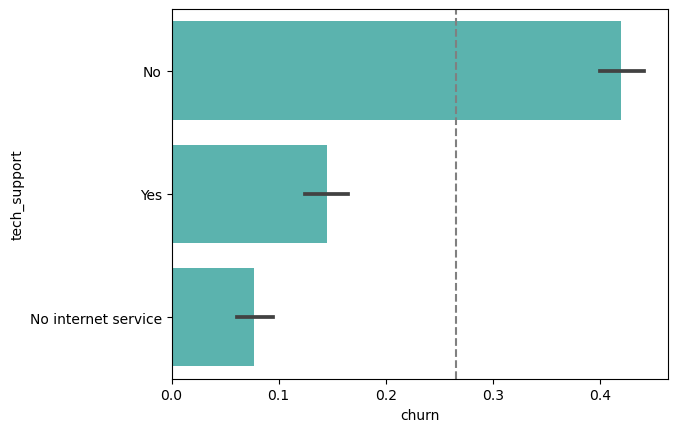

In [7]:
e.explore_cat(train,'churn','tech_support')

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that tech support and churn are not independent from each other. I believe that using `tech_support` in the modeling will have a positive impact on the accuracy.**

### 4) Is Churn independent from a customer having at least one internet package?
* `Churn` is **NOT** independent from having an `internet package`
* Discrete (churn) vs Discrete (has_internet_package) = $Chi^2$
    - $Chi^2$ = 19.128273312412432
    - $p$ = 1.2222085951621455e-05
* $H_0$: Churn is independent from having an internet package
* $H_a$: Churn is **NOT** independent from having an internet package

Chi2: 19.128273312412432, p-value: 1.2222085951621455e-05


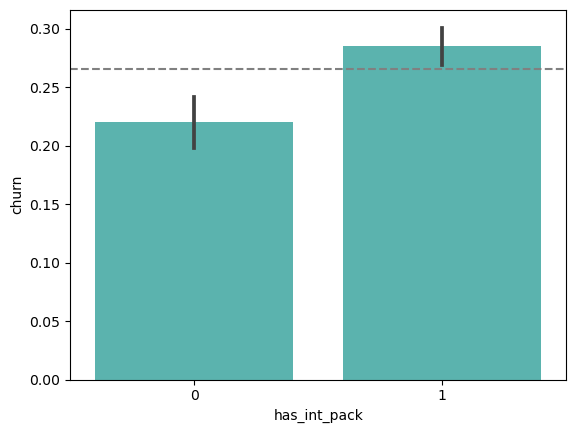

In [8]:
e.explore_int(train,'churn','has_internet_package')

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that having an internet package and churn are not independent from each other. I believe that using `has_internet_package` in the modeling will have a positive impact on the accuracy.**

### Are there any features that are independent from Churn?
* `Churn` **is** independent from both `gender` and `phone_service`
* Discrete (churn) vs Discrete (gender) = $Chi^2$
    - $Chi^2$ = 1.4668271981736136 
    - $p$ = 0.22584695828761636
* $H_0$: Churn is independent from gender
* $H_a$: Churn is **NOT** independent from gender
* Discrete (churn) vs Discrete (phone_service) = $Chi^2$
    - $Chi^2$ = 0.0 
    - $p$ = 1.0
* $H_0$: Churn is independent from phone service
* $H_a$: Churn is **NOT** independent from phone service

Chi2: 1.4668271981736136, p-value: 0.22584695828761636


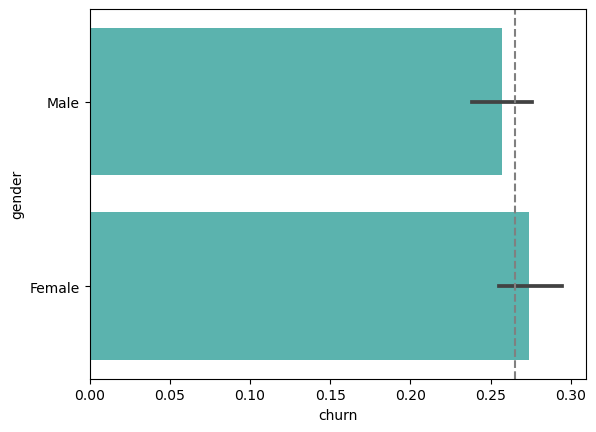

In [9]:
e.explore_cat(train,'churn','gender')

Chi2: 0.0, p-value: 1.0


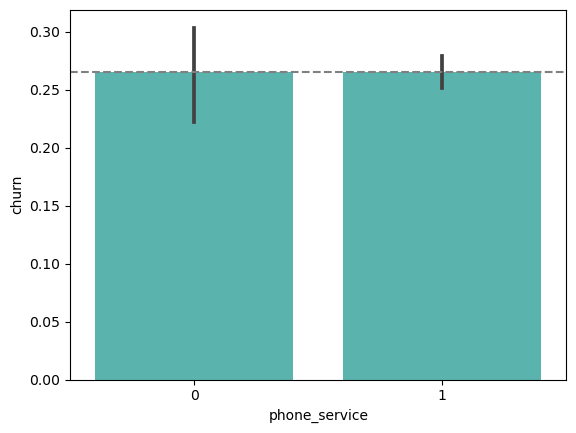

In [10]:
e.explore_int(train,'churn','phone_service')

**With an alpha of 0.05 (confidence 95%) the p-values are greater than alpha. Therefore, evidence suggests that gender and phone service vs churn are independent from each other. I believe that using `gender` and `phone_service` in the modeling will not have much of an impact on the accuracy.**

## Exploration Summary
* Payment type was found to be a driver of churn
    - Electronic check being the most common among churn
* Internet service type was found to be a driver of churn
    - Fiber optic being the most common among churn
* Tech support was found to be a driver of churn
    - No tech support being the most common among churn
* Having an internet package was found to be a driver of churn
    - I would like to investigate why without making assumptions


* Gender and phone service were found to not be a driver of churn

### Features for modeling
* At a minimum these features will be used:
    - churn (target)
    - payment type
    - internet service type
    - tech support
    - has internet package
* Features that will not be used
    - gender
    - phone service
    - multiple lines
        - directly related to phone service

## Modeling

* Accuracy will be the evaluation metric
* Target feature is Churn
    - 27% Churn
    - 73% Active
* Guessing Active for every customer gives an accuracy of 73%
    - 73% will be the baseline accuracy
* Models will be developed and evaluated using 4 different model types and various hyperparameter configurations
    - Decision Tree
    - Random Forest
    - KNN
    - Logistic Regression
* Models will be evaluated on train and validate datasets
* Best performing model will be the only one evaluated on the test dataset

In [11]:
e.baseline(train.churn)

Baseline: 73.47% Accuracy


### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

### Model Type

In [12]:
# Code that runs the best model in that model type goes here 
# (This may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on train: "evaluation result" <br>
"evaluation metric" on validate: "evaluation result"

### Test Model
* Choose the best model out of the three as you best model and explain why you have chosen it
* Explain that you will now run your final model on test data to gauge how it will perform on unseen data

In [13]:
# Code that runs the best overall model on test data (this may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

### Summery
* Summarize your findings and answer the questions you brought up in explore 
* Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**

# README

Your README should contain all of the following elements:

* **Title** Gives the name of your project
* **Project Description** Describes what your project is and why it is important 
* **Project Goal** Clearly states what your project sets out to do and how the information gained can be applied to the real world
* **Initial Hypotheses** Initial questions used to focus your project 
* **Project Plan** Guides the reader through the different stages of the pipeline as they relate to your project
* **Data Dictionary** Gives a definition for each of the features used in your report and the units they are measured in, if applicable
* **Steps to Reproduce** Gives instructions for reproducing your work. i.e. Running your notebook on someone else's computer.